In [1]:
# librairies nécessaires

import numpy as np
import pandas as pd

# graphique
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# normalisation
from sklearn.preprocessing import StandardScaler

# clustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

# divers
from collections import Counter
import time
from datetime import timedelta
begin_time = time.time()

# options
# pd.set_option('display.width', 150)
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 50)

In [2]:
# methodes utiles

# affichage sous forme de tableau côte à côte
from IPython.display import display_html
from itertools import chain,cycle

def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

***
<a id="hautdepage"></a>
## Table des matières:
* Chargement & récapitulatif du dataframe global
* [Incidence de la popularité des morceaux](#popularite)
 * [Popularité & score de sentiment](#pop_sent)
 * [Popularité & spécificité des morceaux](#pop_specs)
* [Clusters par spécificités de morceaux](#cluster_type)
* [Vectorizer & hashtags](#vecto_hashtag)
* [Styles musicaux & spécificités musicales](#style_specs)


***
# Chargement et récapitulatif du dataframe global
[retour en haut de page](#hautdepage)

In [3]:
df_global = pd.read_csv("df_global.csv")

In [4]:
df_global.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6356931 entries, 0 to 6356930
Data columns (total 18 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   index             6356931 non-null  int64  
 1   user_id           6356931 non-null  int64  
 2   track_id          6356931 non-null  object 
 3   artist_id         6356931 non-null  object 
 4   created_at        6356931 non-null  object 
 5   instrumentalness  6356931 non-null  float64
 6   liveness          6356931 non-null  float64
 7   speechiness       6356931 non-null  float64
 8   danceability      6356931 non-null  float64
 9   valence           6356931 non-null  float64
 10  loudness          6356931 non-null  float64
 11  tempo             6356931 non-null  float64
 12  acousticness      6356931 non-null  float64
 13  energy            6356931 non-null  float64
 14  region            6356931 non-null  object 
 15  hashtag           6356931 non-null  object 
 16  

<u>RAPPEL :</u> Le dataframe global a été constitué comme suit (cf notebook `"projDS-00-fichiers"`) :<br/>
<blockquote> enrichissement du fichier des utilisateurs "nettoyé" <i>df_usertrack (user_track_hashtag_timestamp.csv)</i><br>
par le dictionnaire des sentiments recalculés (moyenne) dans le fichier  <i>df_sentiment (sentiment_values.csv)</i> => merge sur le hashtag<br>
puis par les spécificités du morceau présents dans le fichier <i>df_context (context_content_features.csv)</i> => merge sur le track_id
</blockquote>
    
<br>
Ce dataframe global
<ul>
    <li>ne contient pas les hashtag de type nowplaying, ils ont été supprimés</li>
    <li>contient des hashtags qui ne sont pas identifiés dans le dictionnaire sentiment (donc sans "score de sentiment")</li>
    <li>contient parfois plusieurs fois le même morceau pour un même utilisateur</li>
</ul>

In [5]:
# données avec hashtag identifiés ou pas dans le fichier sentiment (donc avec valeur sentiment)
df_global['hashtag_found'].value_counts()

0    5925025
1     431906
Name: hashtag_found, dtype: int64

In [6]:
# morceaux renseignés plusieurs fois par un même utilisateur
pd.DataFrame(df_global[['track_id','user_id']].groupby(['track_id','user_id']).size().reset_index(name='count')).sort_values(by='count', ascending=False)


,track_id,user_id,count
494788,e24deb4963769d25e2c03ad9bf58a028,534492902,41096
494786,e24deb4963769d25e2c03ad9bf58a028,531451640,19527
246457,7188f922ba73eb2509c02d15ec62ff0e,15518784,10326
378119,acca7456f99b4699871d3fe249e5fe11,1617892824,6561
7653,02f5cf0eb2798bc9a1d3fc3c2c83267b,1617892824,6330
...,...,...,...
385462,affacb1b797eabe29f5fce6c31cc6c99,452303470,1
385463,affacb1b797eabe29f5fce6c31cc6c99,2320944312,1
385465,affacb1b797eabe29f5fce6c31cc6c99,2772256712,1
385466,affacb1b797eabe29f5fce6c31cc6c99,2776526095,1


***
<a id="popularite"></a>
# Incidence de la popularité des morceaux 

Popularité (bonne ou mauvaise) = nombre d'utilisateurs **différents** ayant renseignés le même morceau
<br>
[retour en haut de page](#hautdepage)

<a id="pop_sent"></a>
**Existence d'un lien entre popularité & score de sentiment ?**

Le dataframe contient parfois plusieurs fois le même morceau pour un même utilisateur.
<br>Dédoublonnage puis analyse du lien entre popularité et score de sentiment.


In [7]:
# un seul couple user & track (car parfois un utilisateur renseigne plusieurs fois le même morceau)
df_1user_1track = df_global.drop_duplicates(subset=['user_id', 'track_id'], keep='last')

# on ne conserve que les entrées avec des scores de sentiment
df_1user_1track = df_1user_1track[df_1user_1track['hashtag_found']==1]

In [8]:
df_1user_1track.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40194 entries, 433 to 6356910
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             40194 non-null  int64  
 1   user_id           40194 non-null  int64  
 2   track_id          40194 non-null  object 
 3   artist_id         40194 non-null  object 
 4   created_at        40194 non-null  object 
 5   instrumentalness  40194 non-null  float64
 6   liveness          40194 non-null  float64
 7   speechiness       40194 non-null  float64
 8   danceability      40194 non-null  float64
 9   valence           40194 non-null  float64
 10  loudness          40194 non-null  float64
 11  tempo             40194 non-null  float64
 12  acousticness      40194 non-null  float64
 13  energy            40194 non-null  float64
 14  region            40194 non-null  object 
 15  hashtag           40194 non-null  object 
 16  sent_score        40194 non-null  fl

In [9]:
# popularité 
# nb d'utilisateurs différents ayant renseigné le même morceau
pop = pd.DataFrame(df_1user_1track[['track_id','user_id']].groupby(['track_id']).size().reset_index(name='popularite')).sort_values(by='popularite', ascending=False)
pop

,track_id,popularite
8072,5758909ef03fc3a2efaa57408ad43f22,50
5647,3d02f9fcad37e6bb227682761039498c,49
9142,6395d4b468d18225bd8617a1029112c8,47
19808,d6b1124fdd64c4b1afa59f967397111d,45
7306,4ec07b731bb57fc74ddfaa15bc3f1a1c,32
...,...,...
9252,64bb3c10a78fe7be6cbe7ce42afcfb42,1
9251,64ba29072b2c0d5fcbe02e2dce3b1c75,1
9250,64b618dc96440e06aa036be441863658,1
9249,64b30f6ac1acecb7cef9dc890e1c3ea7,1


In [10]:
# distribution des scores de popularité
pd.DataFrame(pop['popularite'].value_counts()).sort_index().rename(columns={'popularite': 'nb'}).rename_axis('popularite')

,nb
popularite,
1,16656
2,3607
3,1397
4,707
5,407
6,258
7,179
8,100
9,57


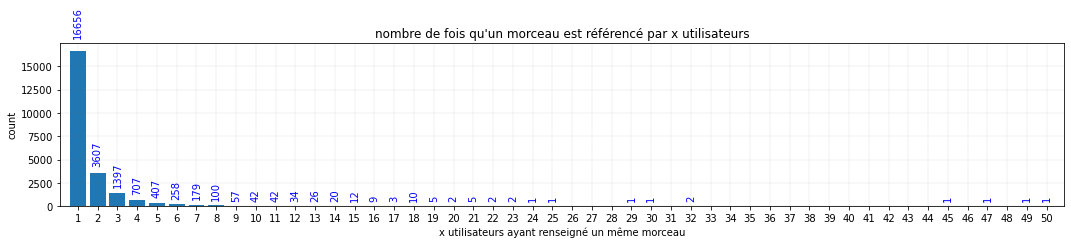

In [11]:
# affichage graphique de la distribution des scores de popularité
labels, counts = np.unique(pop['popularite'], return_counts=True)

fig, ax = plt.subplots()
fig.set_figwidth(18)
fig.set_figheight(3)

arr = plt.bar(labels, counts, align='center')

# affichage du nb de référencement (valeur count de l'histogramme)
for rect in arr:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1.05*height+500,
            '%d' % int(height),
            ha='center', va='bottom', rotation=90, color="blue")

ax.set_xticks(np.arange(0, 51, step=1));
ax.margins(x=0.01)
ax.grid(color='gray', linestyle='-', linewidth=.1)
ax.set_title('nombre de fois qu\'un morceau est référencé par x utilisateurs')
ax.set_xlabel('x utilisateurs ayant renseigné un même morceau')
ax.set_ylabel('count')

plt.show();

Morceaux référencés :
- il existe 1 morceau référencé par 45, 47, 49 ou 50 utilisateurs
- il existe 16 656 morceaux référencés par 1 utilisateur

Si l'on ne se préoccupe que des morceaux les plus référencés on écarte la grande majorité des morceaux.<br>
Reste à voir si le fait qu'un morceau soit très référencé (forte popularité) ou peu référencé (faible popularité) à une incidence sur son score de sentiment.


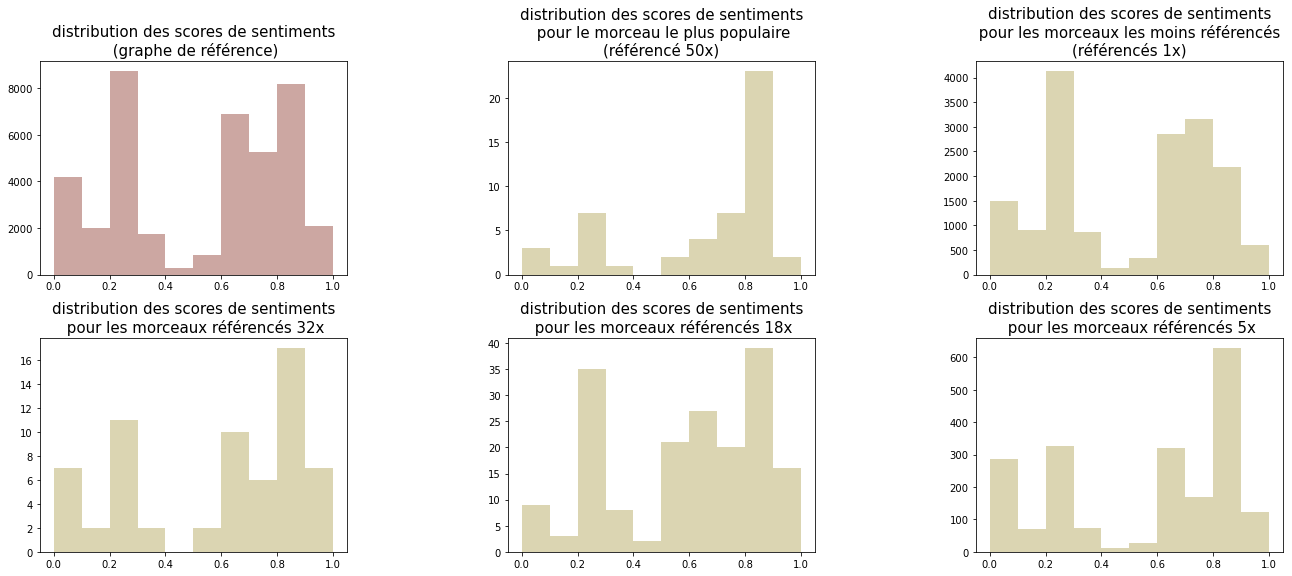

In [12]:
# plt.figure(figsize=(20,10),pad=3.0)
fig, axes = plt.subplots(nrows=2, ncols=3)
fig.tight_layout()
fig.set_figwidth(20)
fig.set_figheight(8)

# distribution des scores de sentiment - référence
axes[0,0].hist(df_1user_1track['sent_score'], color='#CCA7A2');
axes[0,0].set_title(f'distribution des scores de sentiments\n (graphe de référence)', fontsize=15);

# distribution des scores de sentiment pour le morceau le plus référencé (+ forte popularité)
most_popular_track_id = pop[(pop['popularite'] == pop['popularite'].max())]['track_id'].values[0]
axes[0,1].hist(df_1user_1track[df_1user_1track['track_id'] == most_popular_track_id]['sent_score'], color='#DBD5B2');
axes[0,1].set_title(f'distribution des scores de sentiments\n pour le morceau le plus populaire\n(référencé 50x)', fontsize=15);

# distribution des scores de sentiment pour les morceaux les moins populaires (référencés 1x)
popularity_1user_per_track_id = pop[(pop['popularite'] == 1)]['track_id']
axes[0,2].hist(df_1user_1track[(df_1user_1track['track_id'].isin(popularity_1user_per_track_id))]['sent_score'], color='#DBD5B2');
axes[0,2].set_title(f'distribution des scores de sentiments\n pour les morceaux les moins référencés \n(référencés 1x)', fontsize=15);

# distribution des scores de sentiment pour les morceaux référencés 32x
popularity_32user_per_track_id = pop[(pop['popularite'] == 32)]['track_id']
axes[1,0].hist(df_1user_1track[(df_1user_1track['track_id'].isin(popularity_32user_per_track_id))]['sent_score'], color='#DBD5B2');
axes[1,0].set_title(f'distribution des scores de sentiments\n pour les morceaux référencés 32x', fontsize=15);

# distribution des scores de sentiment pour les morceaux référencés 18x
popularity_18user_per_track_id = pop[(pop['popularite'] == 18)]['track_id']
axes[1,1].hist(df_1user_1track[(df_1user_1track['track_id'].isin(popularity_18user_per_track_id))]['sent_score'], color='#DBD5B2');
axes[1,1].set_title(f'distribution des scores de sentiments\n pour les morceaux référencés 18x', fontsize=15);

# distribution des scores de sentiment pour les morceaux référencés 5x
popularity_5user_per_track_id = pop[(pop['popularite'] == 5)]['track_id']
axes[1,2].hist(df_1user_1track[(df_1user_1track['track_id'].isin(popularity_5user_per_track_id))]['sent_score'], color='#DBD5B2');
axes[1,2].set_title(f'distribution des scores de sentiments\n pour les morceaux référencés 5x', fontsize=15);


Il ne semble pas y avoir de lien entre la popularité d'un morceau (nombre d'utilisateurs distincts l'ayant référencé) et son score de sentiments.

<br>
<u>Investigation avec les moyennes de score de sentiment par popularité de morceau :</u>

In [13]:
# pivot table sur track > moyenne des scores & nombre d'utilisateurs ayant référencé le track 
pop_sent = pd.pivot_table(df_1user_1track[['track_id', 'user_id', 'sent_score']],
                     values=['user_id', 'sent_score'],
                     index=['track_id'],
                     aggfunc={'user_id': lambda x: len(x.unique()),
                              'sent_score': np.mean})
pop_sent = pop_sent.sort_values(by=['user_id', 'sent_score'], ascending=False)

# beaucoup de valeurs à 1
# => sélections des morceaux ayant > min_user utilisateurs 
min_popularite=15
pop_sent[pop_sent['user_id']>min_popularite].head()

,sent_score,user_id
track_id,,
5758909ef03fc3a2efaa57408ad43f22,0.648646,50
3d02f9fcad37e6bb227682761039498c,0.670344,49
6395d4b468d18225bd8617a1029112c8,0.740448,47
d6b1124fdd64c4b1afa59f967397111d,0.652998,45
4ec07b731bb57fc74ddfaa15bc3f1a1c,0.630794,32


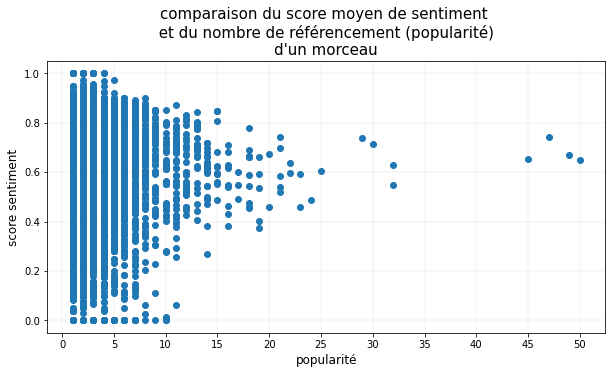

In [14]:
# graphique score moyen de sentiment et popularité
plt.figure(figsize=(10,5))

plt.scatter(x=pop_sent['user_id'],y=pop_sent['sent_score'])

plt.title(f'comparaison du score moyen de sentiment \n et du nombre de référencement (popularité) \nd\'un morceau', fontsize=15)
plt.xlabel('popularité', fontsize=12)
plt.ylabel('score sentiment', fontsize=12)

plt.xticks(np.arange(0, 55, step=5))
plt.grid(color='gray', linestyle='-', linewidth=.1);

Une tendance semble se dessiner pour les scores minis, à partir de 10 utilisateurs écoutant le morceau.

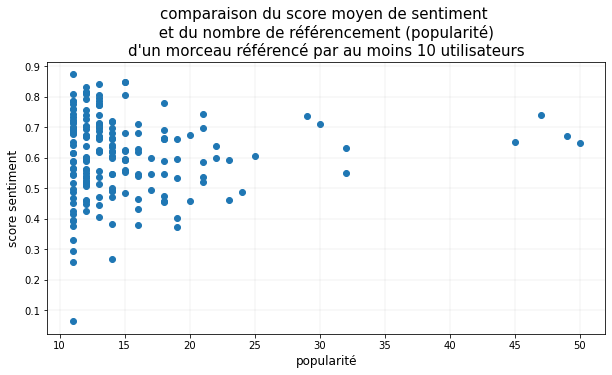

In [15]:
# graphique score moyen de sentiment et popularité
# pour un morceau référencé au moins 10x

min_popularite=10
                                    
plt.figure(figsize=(10,5))

plt.scatter(x = pop_sent[pop_sent['user_id']>min_popularite][['user_id']],
            y = pop_sent[pop_sent['user_id']>min_popularite][['sent_score']])

plt.title(f'comparaison du score moyen de sentiment \n et du nombre de référencement (popularité) \nd\'un morceau référencé par au moins {min_popularite} utilisateurs', fontsize=15)
plt.xlabel('popularité', fontsize=12)
plt.ylabel('score sentiment', fontsize=12)

plt.xticks(np.arange(10, 55, step=5))
plt.grid(color='gray', linestyle='-', linewidth=.1);

Bon... finalement c'est pas si parlant que ça ^^

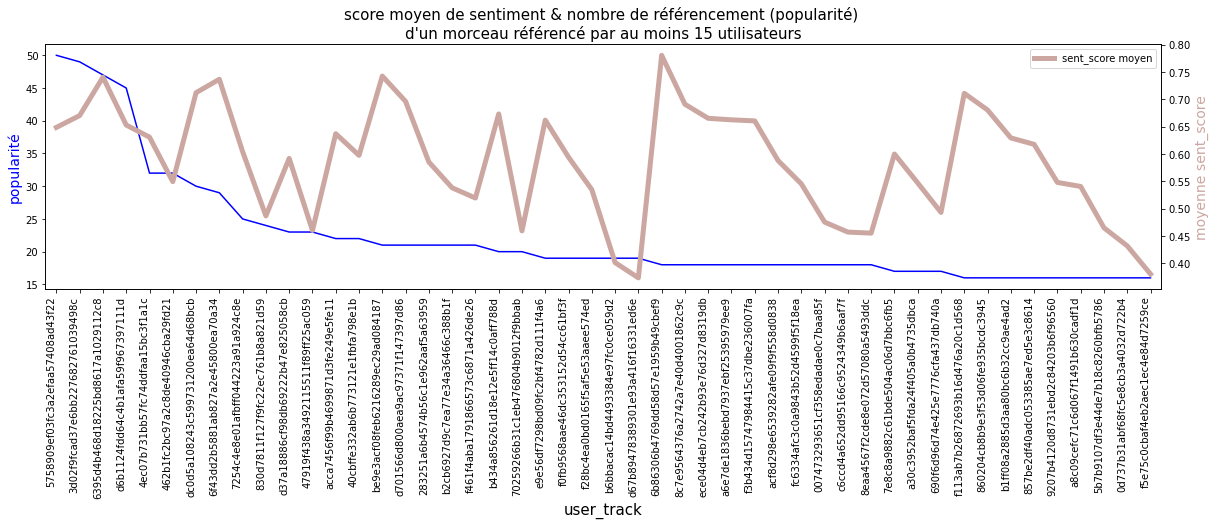

In [16]:
# graphique score moyen de sentiment et popularité
min_popularite=15

fig, ax1 = plt.subplots(figsize=(20, 5))
fig.autofmt_xdate(rotation=90)

ax2 = ax1.twinx()
ax1.margins(x=0.01)
ax1.plot(pop_sent[pop_sent['user_id']>min_popularite][['user_id']], c='blue', label="popularité")
ax2.plot(pop_sent[pop_sent['user_id']>min_popularite][['sent_score']], c="#CCA7A2", linewidth=5, label="sent_score moyen")

ax1.set_xlabel('user_track', fontsize=15)
ax1.set_ylabel('popularité', color='blue', fontsize=14)
ax2.set_ylabel('moyenne sent_score', color='#CCA7A2', fontsize=14)

plt.title(f'score moyen de sentiment & nombre de référencement (popularité) \nd\'un morceau référencé par au moins {min_popularite} utilisateurs', fontsize=15)

plt.legend();



[retour en haut de page](#hautdepage)

<a id="pop_specs"></a>
**Existence d'un lien entre popularité & spécificité d'un morceau ?**

(cf recherches de Nico)


[retour en haut de page](#hautdepage)

***
<a id="cluster_type"></a>
# Clusters par spécificités de morceaux


Recherche de clusters par classification mixte pour voir s'il est possible d'identifier des styles de musiques (et ensuite conseiller les mêmes types aux utilisateurs).<br>

Dans un premier temps on ne travaillera que sur le fichier df_context qui contient les spécificités des morceaux.<br>

Pourquoi sur df_context plutôt que sur df_global ?<br>
Parce que df_context (context_content_features.csv) contient des morceaux qui ne sont pas présents dans df_user (user_track_hashtag_timestamp.csv) et donc absents de df_global par définition (df_global est construit à partir de df_user).

Nous créerons un fichier de travail `df_context_light` qui ne contiendra que les spécificités des morceaux de musique, et une seule occurence par morceau.

In [17]:
df_context = pd.read_csv("df_context.csv")

# morceaux de df_context non présents dans user_track et donc absents de df_global
df_context['user_track_found'].value_counts()


1    10333444
0     1281227
Name: user_track_found, dtype: int64

In [18]:
# création du fichier de travail : dédoublonnage par morceau
df_context_light = df_context[['track_id', 'artist_id', 'user_id', 'instrumentalness', 'liveness', 'speechiness', 
            'danceability', 'valence', 'loudness', 'tempo',
            'acousticness', 'energy']]

print("df_context_light avant dedoublonnage: ",df_context_light.shape)

# suppression des morceaux en doublons
df_context_light.drop_duplicates(subset=['track_id'], inplace=True)

print("df_context_light après dedoublonnage: ",df_context_light.shape)

df_context_light avant dedoublonnage:  (11614671, 12)
df_context_light après dedoublonnage:  (346700, 12)


<ipython-input-18-6076f1fa4a72>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_context_light.drop_duplicates(subset=['track_id'], inplace=True)


In [19]:
# sauvegarde du fichier
df_context_light.to_csv('df_context_light.csv', index=False)

In [20]:
# création du fichier de travail (suite) : conservation uniquement des spécificités des morceaux
# + index track_id pour pouvoir effectuer un merge à la fin

df_context_cluster = df_context_light.drop(columns=['artist_id', 'user_id']).set_index('track_id') 
df_context_cluster
df_context_cluster.describe()

,instrumentalness,liveness,speechiness,danceability,valence,loudness,tempo,acousticness,energy
count,346700.000000,346700.000000,346700.000000,346700.000000,346700.000000,346700.000000,346700.000000,346700.000000,346700.000000
mean,0.176677,0.201058,0.072875,0.528130,0.485919,-8.521765,122.485671,0.247578,0.659483
std,0.311057,0.169192,0.079769,0.170656,0.257421,4.275273,29.421270,0.305102,0.241821
min,0.000000,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000
25%,0.000002,0.095700,0.033800,0.411000,0.274000,-10.780000,99.936000,0.004980,0.489000
50%,0.000761,0.131000,0.044700,0.534000,0.478000,-7.620000,120.740000,0.087700,0.700000
75%,0.178000,0.265000,0.073900,0.652000,0.694000,-5.407000,140.059000,0.438000,0.867000
max,0.999000,1.000000,0.965000,0.992000,1.000000,3.651000,245.941000,0.996000,1.000000


In [21]:
# normalisation
scaler = StandardScaler()
df_context_cluster_scaled = pd.DataFrame(scaler.fit_transform(df_context_cluster), columns = df_context_cluster.columns, index=df_context_cluster.index)

In [22]:
df_context_cluster_scaled.describe()

,instrumentalness,liveness,speechiness,danceability,valence,loudness,tempo,acousticness,energy
count,3.467000e+05,3.467000e+05,3.467000e+05,3.467000e+05,3.467000e+05,3.467000e+05,3.467000e+05,3.467000e+05,3.467000e+05
mean,-6.978191e-15,-7.594886e-16,2.970394e-16,-1.005156e-15,-1.856135e-16,1.105327e-16,-5.464808e-16,-2.177272e-15,6.078553e-16
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-5.679891e-01,-1.188342e+00,-9.135682e-01,-3.094715e+00,-1.887645e+00,-1.204094e+01,-4.163173e+00,-8.114633e-01,-2.727152e+00
25%,-5.679824e-01,-6.227135e-01,-4.898459e-01,-6.863552e-01,-8.232404e-01,-5.282092e-01,-7.664422e-01,-7.951408e-01,-7.049952e-01
50%,-5.655426e-01,-4.140750e-01,-3.532018e-01,3.439480e-02,-3.076371e-02,2.109260e-01,-5.933372e-02,-5.240176e-01,1.675508e-01
75%,4.253190e-03,3.779237e-01,1.285416e-02,7.258461e-01,8.083293e-01,7.285545e-01,5.973010e-01,6.241266e-01,8.581441e-01
max,2.643641e+00,4.722096e+00,1.118383e+01,2.718163e+00,1.997044e+00,2.847253e+00,4.196131e+00,2.453029e+00,1.408138e+00


methode de clustering mixte KMeans + ACP :

In [23]:
# cluster
start_time = time.time()

km = KMeans(n_clusters=50)
km.fit(df_context_cluster_scaled)

centroids = km.cluster_centers_
labels = km.labels_

# dendogramme à partir des centres de gravités et des labels de chaque cluster
liens = linkage(centroids, method = 'ward', metric = 'euclidean')

print("--- %s seconds ---" % (time.time() - start_time))
# --- 267.47092723846436 seconds ---


--- 205.89496850967407 seconds ---


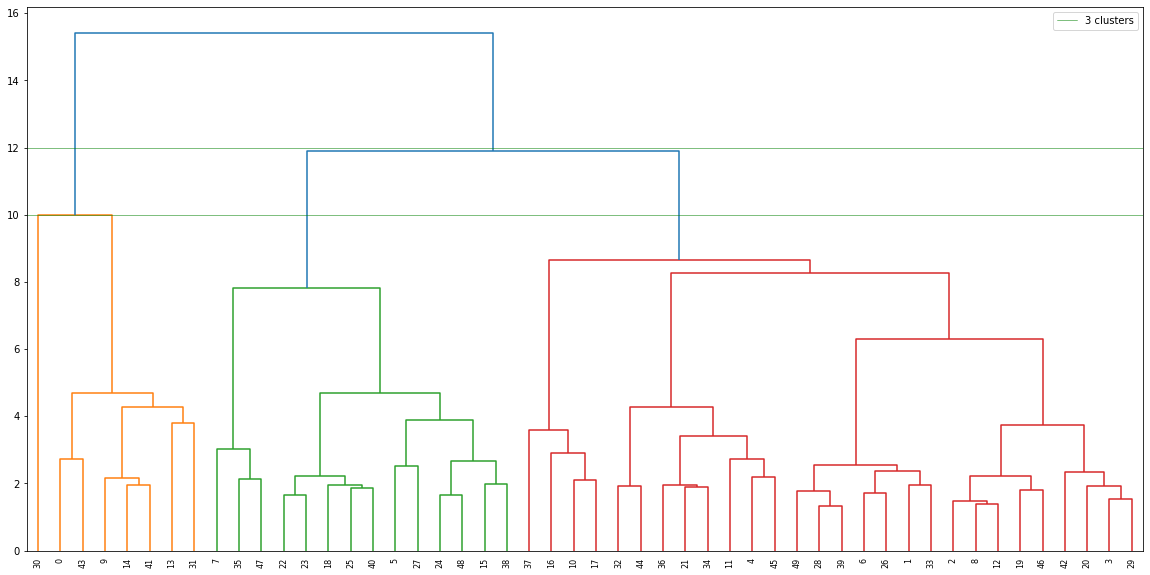

In [24]:
plt.figure(figsize=(20,10))
dendrogram(liens, leaf_rotation = 90);

plt.axhline(y=10, linewidth=.5, color="green", label="3 clusters");
plt.axhline(y=12, linewidth=.5, color="green");

plt.legend();

Dans l'idéal, selon le modèle, 3 clusters (mais ça semble très peu pour catégoriser les morceaux).

In [25]:
# ACP
cluster = AgglomerativeClustering(n_clusters = 3)
cluster.fit(centroids)
cl_labels = cluster.labels_

# ajout du label du cluster au dataframe df_context_light_scaled
for i in range(50):
    df_context_cluster_scaled.loc[labels==i, 'cluster'] = cl_labels[i]

# répartition
df_context_cluster_scaled['cluster'].value_counts()

1.0    227402
2.0     94328
0.0     24970
Name: cluster, dtype: int64

In [26]:
# value_count
cluster_nb_track = pd.DataFrame(df_context_cluster_scaled.groupby('cluster').size(), columns=['nb'])
# %
cluster_nb_track['%'] = np.round(100*(cluster_nb_track['nb']/df_context_cluster_scaled.shape[0]),2)
cluster_nb_track

,nb,%
cluster,,
0.0,24970,7.20
1.0,227402,65.59
2.0,94328,27.21


Une grande majorité des morceaux sont dans le même cluster, ce clustering risque de ne pas être bien utile pour différencier convenablement les styles de musiques..

**Y a t il une cohérence entre les clusters crées et les hashtags ?**

Il faudrait voir si des hashtag reviennent plus souvent que d'autres dans les clusters pour identifier des styles musicaux.

In [27]:
# start_time = time.time()
# Recherche des hashtag correspondants à chaque cluster

# dataframe résultat
# créé sur la base des index = n° de cluster
cluster_hashtags = pd.DataFrame()
cluster_hashtags['id'] = df_context_cluster_scaled['cluster'].unique()
cluster_hashtags.set_index('id', inplace = True)

# dataframe des morceaux track_id et leur cluster
df_track_cluster = df_context_cluster_scaled[['cluster']]

# ---
# alimentation de la variable hashtag du dataframe par les hashtag des track_id du cluster

# iteration sur les n° de cluster // df_context_cluster_scaled['cluster'].unique() ou cluster_hashtags.index
for val in cluster_hashtags.index :
    # inter_time = time.time()
    
    # recupération des track_id du cluster val
    track_id = df_track_cluster[df_track_cluster['cluster']==val].index
    
    # récupération des hashtag de ces morceaux track_id ( + tri par ordre alphabétique et séparés par une virgule et un espace )
    hashtags = ', '.join(df_global[df_global['track_id'].isin(track_id)]['hashtag'].astype('str').sort_values())

    # affectation des hashtag au dataframe résultat
    cluster_hashtags.loc[val,'hashtag'] = hashtags
    
    # check
    # print(f'traitement cluster {val}', " > %s seconds" % (time.time() - inter_time))

# print("--- %s seconds ---" % (time.time() - start_time))

In [28]:
# nb d'éléments affichés 
max_item = 50

hashtag_0 = cluster_hashtags.loc[0,'hashtag']
hashtag_1 = cluster_hashtags.loc[1,'hashtag']
hashtag_2 = cluster_hashtags.loc[2,'hashtag']

res_0 = pd.DataFrame.from_dict(Counter(hashtag_0.split(', ')).most_common(max_item))
res_0.rename(columns={0: "hashtag", 1: "count"}, inplace=True)

res_1 = pd.DataFrame.from_dict(Counter(hashtag_1.split(', ')).most_common(max_item))
res_1.rename(columns={0: "hashtag", 1: "count"}, inplace=True)

res_2 = pd.DataFrame.from_dict(Counter(hashtag_2.split(', ')).most_common(max_item))
res_2.rename(columns={0: "hashtag", 1: "count"}, inplace=True)


In [29]:
# affichage (passer en mode "code" ctrl + y - dans github la fonction display_side_by_side() ne fonctionne pas)
display_side_by_side(res_0, res_1, res_2, titles=['Cluster 0', 'Cluster 1', 'Cluster 2'])

,hashtag,count
0,listenlive,124460
1,tunein,18338
2,hiphop,12223
3,music,9499
4,360wisejamz,9230
5,urbantraxxradio,8841
6,radio,7974
7,streetstyleradio,5608
8,anghami,5353
9,chicagomusic,4756


Il y a des mots très présents mais qui n'apportent aucune information (listenlive, ..)

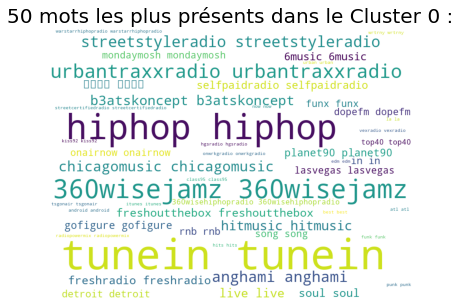

In [30]:
# représentation graphique 
# word count

# https://datascientest.com/wordcloud-python
# https://www.datacamp.com/community/tutorials/wordcloud-python
# conda install -c conda-forge wordcloud
# ou pip install wordcloud
from wordcloud import WordCloud

# suppression des mots très présents et qui n'apportent aucune information
stopwords = ['listenlive', 'music', 'radio']

# wordcloud = WordCloud(background_color = 'white', stopwords = exclure_mots, max_words = 50).generate(text)

# cluster 0
wordcloud = WordCloud(stopwords=stopwords, 
                      width=800, height=600, 
                      background_color = 'white', 
                      max_words = max_item).generate(hashtag_0)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.axis("off")
plt.title(f'{max_item} mots les plus présents dans le Cluster 0 :', fontsize=20)
plt.show();


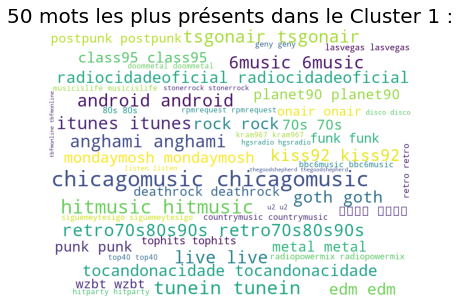

In [31]:
# cluster 1
wordcloud = WordCloud(stopwords=stopwords, 
                      width=800, height=600, 
                      background_color = 'white', 
                      max_words = max_item).generate(hashtag_1)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.axis("off")
plt.title(f'{max_item} mots les plus présents dans le Cluster 1 :', fontsize=20)
plt.show();


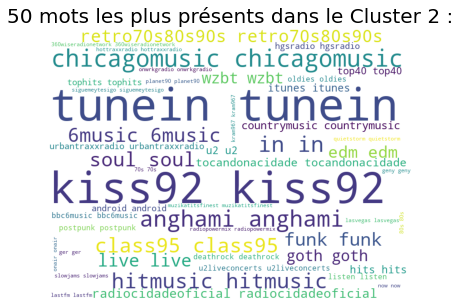

In [32]:
# cluster 2
wordcloud = WordCloud(stopwords=stopwords, 
                      width=800, height=600, 
                      background_color = 'white', 
                      max_words = max_item).generate(hashtag_2)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.axis("off")
plt.title(f'{max_item} mots les plus présents dans le Cluster 2 :', fontsize=20)
plt.show();

Les 3 clusters ne permettent pas de classer efficacement les styles musicaux.

**<u>Nouvelle tentative avec d'avantage de clusters</u>**

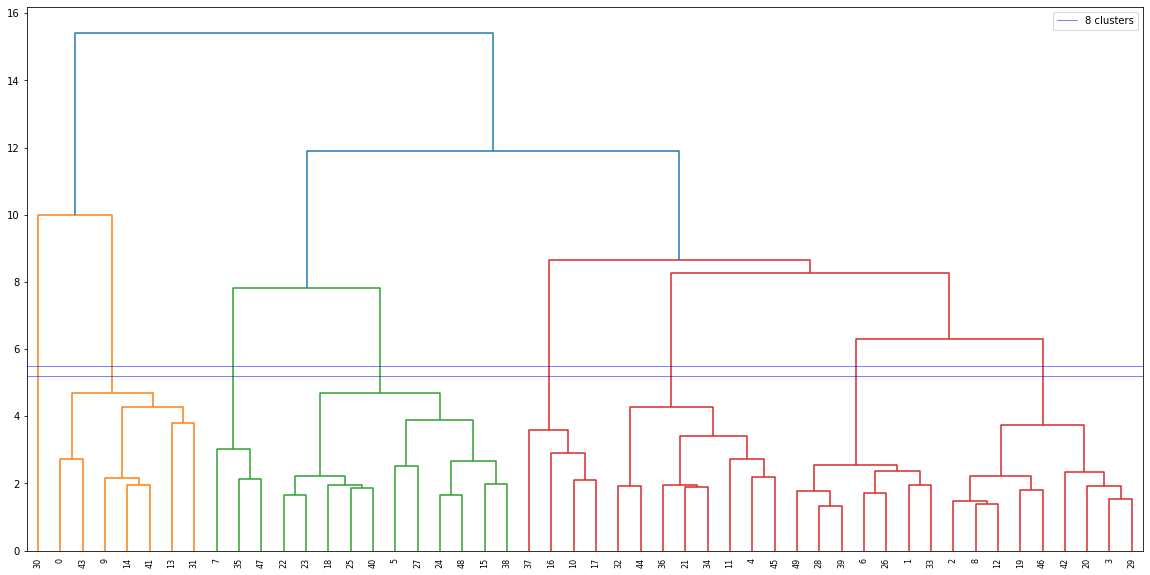

In [33]:
# test avec 8 clusters
plt.figure(figsize=(20,10))
dendrogram(liens, leaf_rotation = 90);

plt.axhline(y=5.2, linewidth=.5, color="blue", label="8 clusters");
plt.axhline(y=5.5, linewidth=.5, color="blue");

plt.legend();

In [34]:
# ACP
cluster = AgglomerativeClustering(n_clusters = 8)
cluster.fit(centroids)
cl_labels = cluster.labels_

# ajout du label du cluster au dataframe df_context_light_scaled
for i in range(50):
    df_context_cluster_scaled.loc[labels==i, 'cluster'] = cl_labels[i]

# répartition
cluster_nb_track = pd.DataFrame(df_context_cluster_scaled.groupby('cluster').size(), columns=['nb'])
# %
cluster_nb_track['%'] = np.round(100*(cluster_nb_track['nb']/df_context_cluster_scaled.shape[0]),2)
cluster_nb_track

,nb,%
cluster,,
0.0,82966,23.93
1.0,24267,7.00
2.0,51341,14.81
3.0,67029,19.33
4.0,15823,4.56
5.0,93209,26.88
6.0,11362,3.28
7.0,703,0.20


In [35]:
# dataframe résultat

# créé sur la base des index = n° de cluster
cluster_hashtags = pd.DataFrame()
cluster_hashtags['id'] = df_context_cluster_scaled['cluster'].unique()
cluster_hashtags.set_index('id', inplace = True)

# dataframe des morceaux track_id et leur cluster
df_track_cluster = df_context_cluster_scaled[['cluster']]

# alimentation de la variable hashtag du dataframe par les hashtag des track_id du cluster

# iteration sur les n° de cluster // df_context_cluster_scaled['cluster'].unique() ou cluster_hashtags.index
for val in cluster_hashtags.index :    
    # recupération des track_id du cluster val
    track_id = df_track_cluster[df_track_cluster['cluster']==val].index
    
    # récupération des hashtag de ces morceaux track_id ( + tri par ordre alphabétique )
    hashtags = ', '.join(df_global[df_global['track_id'].isin(track_id)]['hashtag'].astype('str').sort_values())

    # affectation des hashtag au dataframe résultat
    cluster_hashtags.loc[val,'hashtag'] = hashtags

Ces nouveaux groupes de clusters correspondent-ils à des styles musicaux en particulier ?

In [36]:
# nb max d'éléments affichés
max_item = 50

res = []
for val in cluster_hashtags.index :  
    res.append(pd.DataFrame.from_dict(Counter(cluster_hashtags.loc[val,'hashtag'].split(', ')).most_common(max_item)))


In [37]:
some_hashtags = ['funk', 'soul', 'rock', 'jazz', 'deathrock', 'punk', 'hiphop']

# dataframe matrice hashtag / cluster pour les some_hashtags

# n° de clusters
cols = [i for i, clust in enumerate(res)]

# dataframe de 0 avec une ligne par hashtag et les n° de clusters en colonnes
hashtag_cluster = pd.DataFrame(0, index=np.arange(len(some_hashtags)), columns=cols) 
hashtag_cluster.index = some_hashtags # index = hashtag
# hashtag_cluster

# on rajoute des 1 là où il y a correspondance hashtag / cluster :
for i, clust in enumerate(res):
    for hashtag in some_hashtags:
        if (hashtag in clust[0].tolist()):
            hashtag_cluster.loc[hashtag,i] = 1

print("présence des hashtags dans les clusters :")
display(hashtag_cluster)


présence des hashtags dans les clusters :


,0,1,2,3,4,5,6,7
funk,1,1,0,1,1,1,0,0
soul,1,1,0,0,0,1,0,0
rock,0,0,1,1,1,0,1,0
jazz,0,0,0,1,0,0,1,1
deathrock,1,0,1,1,1,0,1,0
punk,0,1,1,1,1,0,0,0
hiphop,0,0,0,0,0,1,0,1


Cet exercice nous permet au moins d'identifier les hashtags très présents et sans intérêt : listenlive, music, radio, tunein, in, android, ...

Mais pas d'identifier des clusters de styles de musiques.<br>

En effet, de nombreux hashtags se retrouvent dans plusieurs clusters, <br>
et certains hashtags représentants des styles de musiques bien différents se retrouvent dans le même cluster.


[retour en haut de page](#hautdepage)

***
<a id="vecto_hashtag"></a>
# Vectorizer & hashtags
A faire


[retour en haut de page](#hautdepage)

<a id="style_specs"></a>
# Styles musicaux & spécificités musicales

Est-ce que les styles musicaux identifiés par Nico sont reconnaissables par leur spécificités musicales ?

In [38]:
# styles musicaux identifiés par Nico
df_style = pd.read_csv('genres-nico.csv', header=None, names=['style'])
df_style['genre'] = df_style['style'].str.lower()

print(len(df_style['style'].to_list()),"styles musicaux :\n",df_style['genre'].to_list())
# df_global[df_global['hashtag']=='soundtrack']

75 styles musicaux :
 ['acoustic', 'african', 'afrobeat', 'alternative', 'ambient', 'ambient electronic', 'asia', 'avant-garde', 'balkan', 'blues', 'brazilian', 'breakbeat', 'british', 'celtic', 'chamber', 'choral', 'classical', 'contemporary', 'country', 'dance', 'disco', 'drum', 'dubstep', 'electro', 'experimental', 'fado', 'flamenco', 'folk', 'french', 'funk', 'glitch', 'gospel', 'goth', 'grindcore', 'hardcore', 'hiphop', 'hip-hop', 'house', 'indian', 'industrial', 'instrumental', 'international', 'jazz', 'jungle', 'latin', 'lo-fi', 'lounge', 'metal', 'middleeast', 'minimalism', 'nerdcore', 'new age', 'newage', 'newwave', 'noise', 'opera', 'polka', 'pop', 'progressive', 'psych', 'punk', 'rap', 'reggae', 'rnb', 'rock', 'salsa', 'soul', 'soundtrack', 'spanish', 'symphony', 'tango', 'techno', 'triphop', 'trip-hop', 'turkish']


In [43]:
# analyse des spécificités de quelques hashtags
some_hashtags = ['funk', 'soul', 'rock', 'jazz', 'deathrock', 'punk', 'hiphop', 'classic']

# creation d'un dataframe contenant les spécificités des hashtags choisis
df_track_style = df_global[df_global['hashtag'] == some_hashtags[0]].drop_duplicates(subset=['track_id'], keep='last')

for i in np.arange(1,len(some_hashtags)):
    # print(some_hashtags[i])
    df_track_style = df_track_style.append(df_global[df_global['hashtag'] == some_hashtags[i]].drop_duplicates(subset=['track_id'], keep='last'))

# suppression des variables inutiles pour l'analyse
df_track_style.drop(columns=['index','user_id','artist_id','created_at', 'region'], inplace=True)

In [40]:
df_track_style

,track_id,instrumentalness,liveness,speechiness,danceability,valence,loudness,tempo,acousticness,energy,hashtag,sent_score,hashtag_found
15328,3d9fb8908110944526d6aa3075044b7d,0.000000,0.2730,0.0654,0.420,0.535,-9.793,101.906,0.25600,0.802,funk,NaN,0
17409,9dde6568efbc011262fb07b0373a96f8,0.000919,0.0833,0.1430,0.865,0.830,-9.046,90.081,0.56600,0.652,funk,NaN,0
18216,58772218e1c471a0c3c6846f91009b0b,0.716000,0.0929,0.0410,0.922,0.907,-8.367,114.261,0.03680,0.737,funk,NaN,0
19500,63720375dc19db9d5f8083f80ad12e43,0.009370,0.1040,0.0588,0.658,0.934,-11.137,112.253,0.00714,0.831,funk,NaN,0
19593,03b9d49a959236c9aa750240d5c27b93,0.000001,0.0817,0.0410,0.614,0.648,-11.970,104.308,0.37500,0.388,funk,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6355347,e301d44110d311b3acc613a348895b6c,0.000000,0.3360,0.2900,0.838,0.838,-6.131,96.643,0.19500,0.705,hiphop,NaN,0
6355640,7e836b6d2e8ed0c9b43000c559c9df04,0.000000,0.3130,0.2500,0.657,0.723,-7.891,81.518,0.34200,0.777,hiphop,NaN,0
6355763,4c20ee8b6070f9c449f2cdbbb39d71df,0.000026,0.2930,0.2790,0.696,0.473,-8.319,91.980,0.01090,0.713,hiphop,NaN,0
6356286,11d73c715f1a0accd0382d71f7fc74d1,0.000027,0.1900,0.0639,0.546,0.249,-3.263,142.123,0.09090,0.796,hiphop,NaN,0


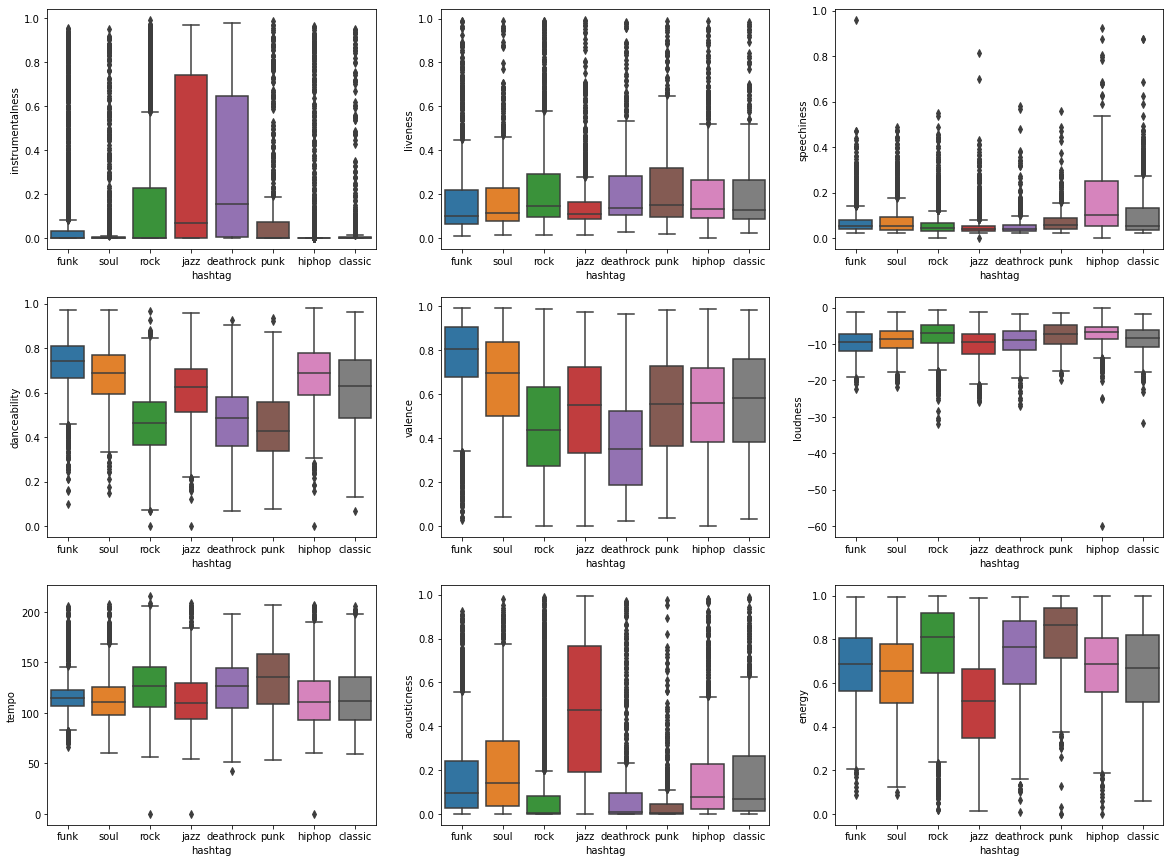

In [44]:
plt.figure(figsize=(20,15))

plt.subplot(331)
sns.boxplot(y='instrumentalness',  x='hashtag', data=df_track_style);

plt.subplot(332)
sns.boxplot(y='liveness',  x='hashtag', data=df_track_style);

plt.subplot(333)
sns.boxplot(y='speechiness',  x='hashtag', data=df_track_style);

plt.subplot(334)
sns.boxplot(y='danceability',  x='hashtag', data=df_track_style);

plt.subplot(335)
sns.boxplot(y='valence',  x='hashtag', data=df_track_style);

plt.subplot(336)
sns.boxplot(y='loudness',  x='hashtag', data=df_track_style);

plt.subplot(337)
sns.boxplot(y='tempo',  x='hashtag', data=df_track_style);

plt.subplot(338)
sns.boxplot(y='acousticness',  x='hashtag', data=df_track_style);

plt.subplot(339)
sns.boxplot(y='energy',  x='hashtag', data=df_track_style);



[retour en haut de page](#hautdepage)

## FIN ---

In [42]:
print("temps d'éxécution total")
print("--- %s seconds ---" % (time.time() - begin_time))
print(timedelta(seconds=round((time.time() - begin_time),0)))


# 0:06:50


temps d'éxécution total
--- 394.21757674217224 seconds ---
0:06:34
